# Compute correlations in longitude bins with no regime averaging

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [65]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/cj50+gdata/ik11+gdata/e14+gdata/hh5+gdata/v45',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )


# and if you want even more power, you can use this to make it three nodes

cluster.scale(jobs=1)


# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/33207/status,
Dashboard: /proxy/33207/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.36:37169,Workers: 0
Dashboard: /proxy/33207/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-295521' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40687,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:34261,Total threads: 4
Dashboard: /proxy/35319/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:46459,


## Load u_along and CSHT if you want to compute correlations from scratch:
Note if these are already calculated, there is section below that opens the already saved correlations and analyses them.

In [ ]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')
u_along_daily = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DailyU_climatology_rho_10deg_bins.nc')

# resample monthly: - not needed here
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

In [ ]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()


In [ ]:
# monthly water mass mask 
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')
age_mask

In [ ]:
daily_age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/****_age_Climatology_mask.nc')
daily_age_mask

In [ ]:
CSHT_daily_along_CDW = CSHT_along*daily_age_mask.CDW_mask
u_daily_along_CDW = u_along_daily*daily_age_mask.CDW_mask
CSHT_daily_along_AASW = CSHT_along*daily_age_mask.AASW_mask
u_daily_along_AASW = u_along_daily*daily_age_mask.AASW_mask

In [ ]:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')
vol_bins

### Do different time averaging to compute correlations on different time scales - daily in this notebook only

In [ ]:
n_bins = len(vol_bins.lon_bins)

In [ ]:
def vol_ave_potrho0_potmask(mask, quantity,vol_bins):
    return (mask * quantity * vol_bins.volume).mean('potrho0')/(mask*vol_bins).mean('potrho0').volume

In [ ]:
# climatology

In [ ]:
# interpolate monthly volume bins to daily and get a climatology
vol_daily_interp = vol_bins.resample(time="1D").interpolate("linear")
vol_daily_interp_noleap = vol_daily_interp.convert_calendar('noleap')
vol_bins_daily_clim = vol_daily_interp_noleap.groupby('time.dayofyear').mean(dim = 'time')

In [ ]:
## use daily climatology volume bins for simplicity + so we dont have to save daily changes
U_along_binned_CDW_daily =  vol_ave_potrho0_potmask(daily_age_mask.CDW_mask ,u_along_daily,vol_bins_daily_clim).load()
U_along_binned_AASW_daily =  vol_ave_potrho0_potmask(daily_age_mask.AASW_mask ,u_along_daily,vol_bins_daily_clim).load()

In [ ]:
U_along_binned_CDW_daily.ASCspeed.max().values

In [ ]:
U_along_binned_CDW_daily.ASCspeed.min().values

## can skip -- plots to check the missing values, rectified now

Task exception was never retrieved
future: <Task finished name='Task-926857' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


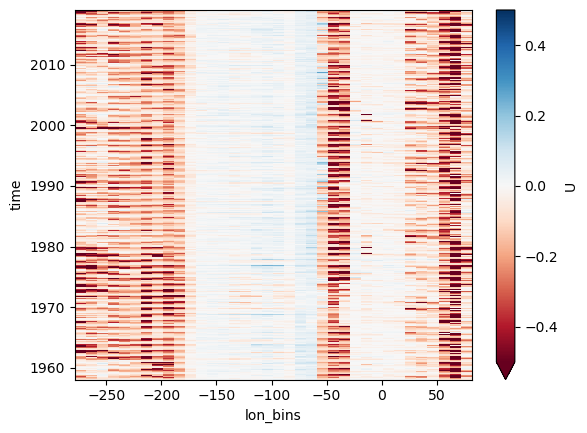

In [88]:
((age_mask.CDW_mask*u_along*vol_bins.volume).mean('potrho0')\
 /(age_mask.CDW_mask*vol_bins).mean('potrho0').volume).U.plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu')
## monthly ASC speed av in CDW layer. 

Text(0.5, 1.0, 'DSW')

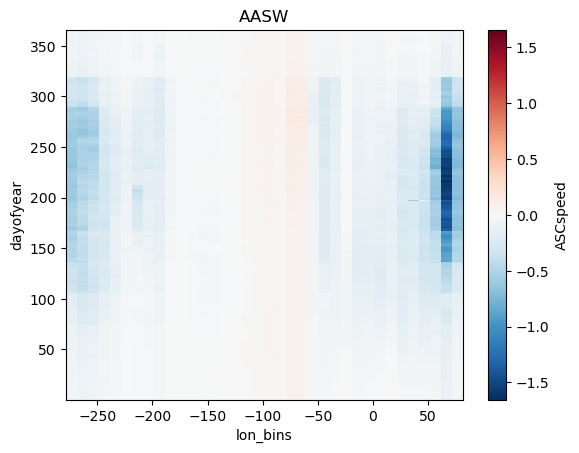

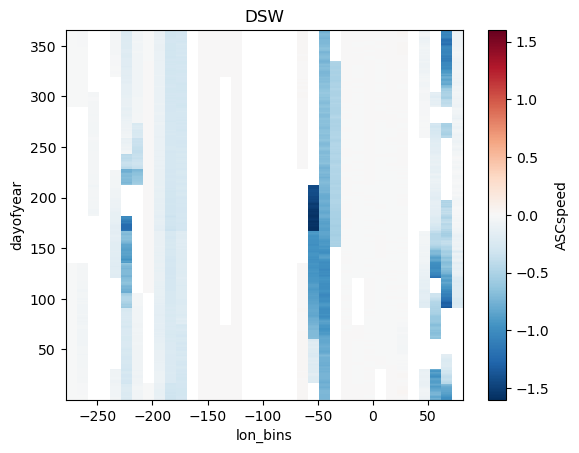

In [16]:
((daily_age_mask.AASW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).ASCspeed.plot()
plt.title('AASW')
plt.figure()
((daily_age_mask.DSW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).ASCspeed.plot(label = 'DSW ASC speed')
plt.title('DSW')
## incorrect weighting - to change


In [92]:
vol_bins

<xarray.Dataset> Size: 23MB
Dimensions:   (potrho0: 108, time: 732, lon_bins: 36)
Coordinates:
  * potrho0   (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    volume    (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>

<xarray.Dataset> Size: 11MB
Dimensions:    (potrho0: 108, dayofyear: 365, lon_bins: 36)
Coordinates:
  * potrho0    (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lon_bins   (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    ASCspeed   (dayofyear, potrho0, lon_bins) float64 11MB dask.array<chunksize=(365, 108, 36), meta=np.ndarray>

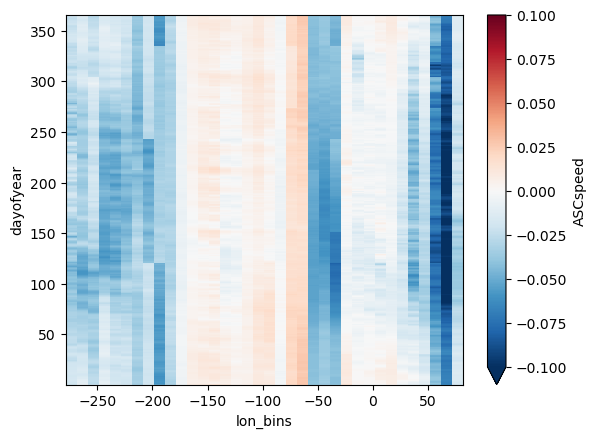

In [94]:
## missing times in ASC speed in CDW layer
#u_along_daily
#((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume)\
#    .ASCspeed.plot(vmax = 2, vmin = -2, cmap = 'RdBu_r')
((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')\
 /(daily_age_mask.CDW_mask*vol_bins_daily_clim).mean('potrho0').volume)\
    .ASCspeed.plot(vmax = 0.1, vmin = -0.1, cmap = 'RdBu_r')
u_along_daily ## corrected weighting

In [18]:
asc_cdw_av_clim = ((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')\
                   /vol_bins_daily_clim.mean('potrho0').volume)
asc_cdw_av_clim.ASCspeed.min().values

array(-3.01378719)

In [19]:
u_along_daily.ASCspeed.min().values

array(-6.00975943)

In [20]:
u_along_daily.ASCspeed.max().values

array(2.14785848)

In [81]:
abs(u_along_daily.ASCspeed).mean().values

array(0.05071992)

In [52]:
mean_CDW_ASC =((daily_age_mask.CDW_mask*u_along_daily* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume)

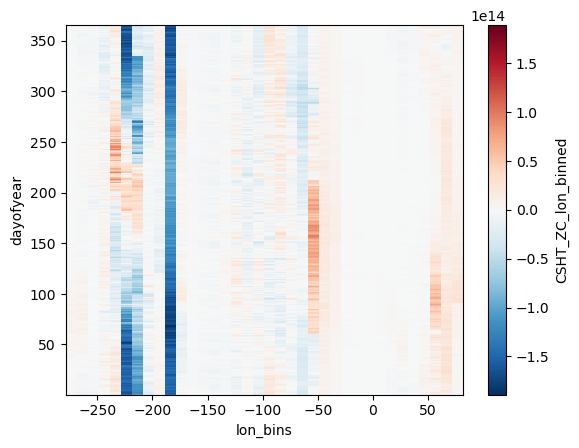

In [18]:
## missing times in ASC speed in CDW layer
((daily_age_mask.CDW_mask*CSHT_along.groupby('time.dayofyear').mean('time')* vol_bins_daily_clim.volume).mean('potrho0')/vol_bins_daily_clim.mean('potrho0').volume).CSHT_ZC_lon_binned.plot()

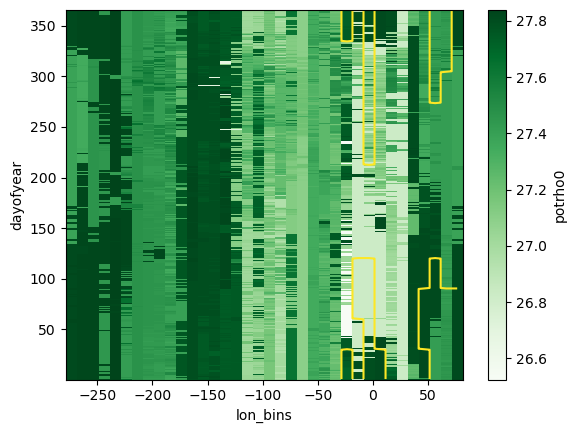

In [63]:
(u_along_daily).idxmax('potrho0').ASCspeed.plot(cmap = 'Greens', cbar_kwargs = {'label': 'potrho0'})
xr.where(mean_CDW_ASC.notnull(),1000,0).ASCspeed.plot.contour(c = 'C1', levels = [500], add_colorbar = False)

In [56]:
mean_CDW_ASC.notnull().ASCspeed.values.plot.contour()

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ..., False, False,  True]])

In [59]:
xr.where(mean_CDW_ASC.notnull(),1000,0).ASCspeed.values

array([[1000, 1000, 1000, ...,    0,    0,    0],
       [1000, 1000, 1000, ...,    0,    0,    0],
       [1000, 1000, 1000, ...,    0,    0,    0],
       ...,
       [1000, 1000, 1000, ...,    0,    0, 1000],
       [1000, 1000, 1000, ...,    0,    0, 1000],
       [1000, 1000, 1000, ...,    0,    0, 1000]])

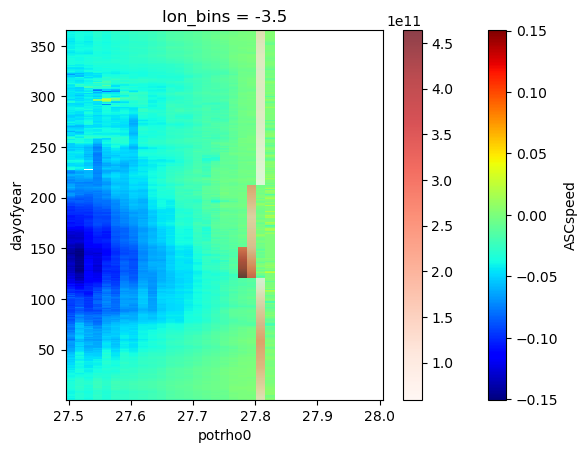

In [21]:
## why there were nan values in correlations --- there are nan values in ASC speed at certain lon -- ASC speed climatology does not include all expected density levels. 
(u_along_daily).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'jet')
(daily_age_mask.CDW_mask* vol_bins_daily_clim.volume).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).plot(cmap = 'Reds', alpha = 0.75)

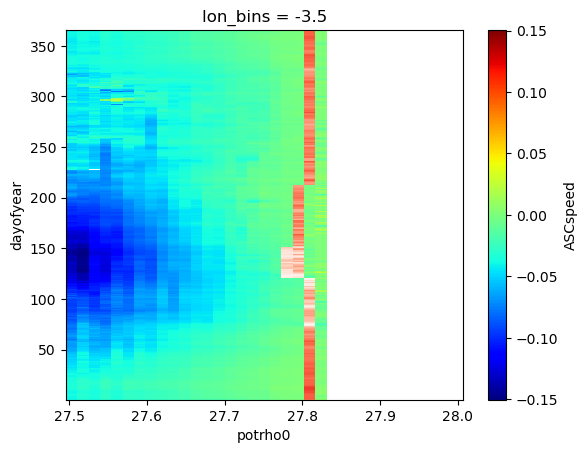

In [22]:
(u_along_daily).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'jet')
(daily_age_mask.CDW_mask*u_along_daily).sel(lon_bins = 0, method = 'nearest').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'Reds', add_colorbar = False)

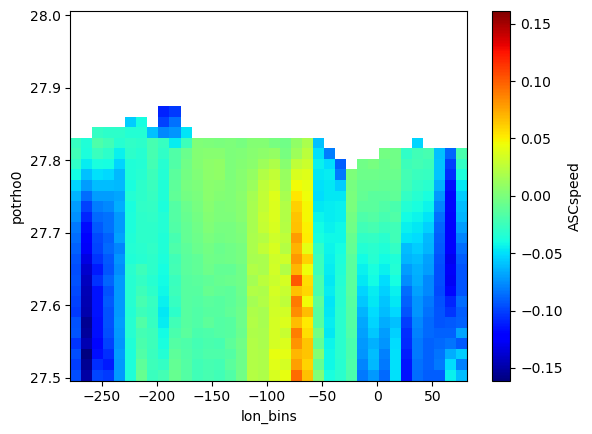

In [158]:
(u_along_daily).mean(dim = 'dayofyear').sel(potrho0 = slice(27.5,28)).ASCspeed.plot(cmap = 'jet')


## return to CDW/AASW correlations

In [129]:
CSHT_binned_CDW_daily =  (daily_age_mask.CDW_mask *CSHT_along.groupby('time.dayofyear').mean('time'))#.sum('potrho0').load()
CSHT_binned_AASW_daily = (daily_age_mask.AASW_mask *CSHT_along.groupby('time.dayofyear').mean('time'))#.sum('potrho0').load()

In [130]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Based on the above, turns out we need to interpolate the volume bins, or else there are days in the climatology with no CDW mass, which is what we wanted to avoid in the first place?

In [131]:
def daily_clima(u_along, CSHT_along):
    u_along_da_clima = u_along#.U_along_contour_binned).sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
    U_along_clima_binned = u_along_da_clima#.mean('dayofyear') #.groupby('time.dayofyear')
    #U_along_clima_binned.load();
    
    CSHT_clima = CSHT_along#((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
    CSHT_clima_binned = CSHT_clima#.mean('dayofyear') #.sel(potrho0=slice(13.8,28.42)).groupby('time.dayofyear')
    #CSHT_clima_binned = CSHT_clima_binned.load()
    return U_along_clima_binned, CSHT_clima_binned.sum('potrho0')

In [132]:
U_along_binned_CDW_daily_clima, CSHT_binned_CDW_daily_clima = daily_clima(U_along_binned_CDW_daily, CSHT_binned_CDW_daily)

In [133]:
U_along_binned_AASW_daily_clima, CSHT_binned_AASW_daily_clima = daily_clima(U_along_binned_AASW_daily, CSHT_binned_AASW_daily)

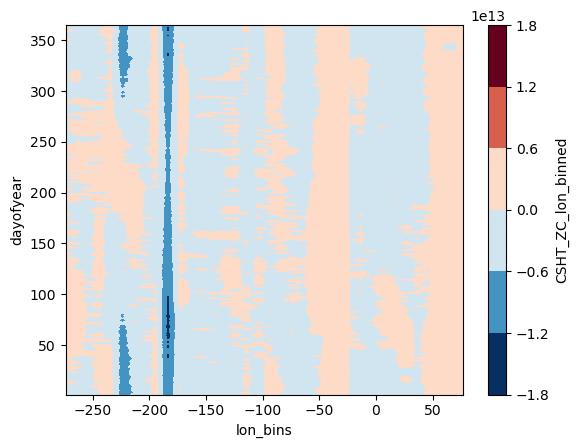

In [136]:
CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned.plot.contourf()

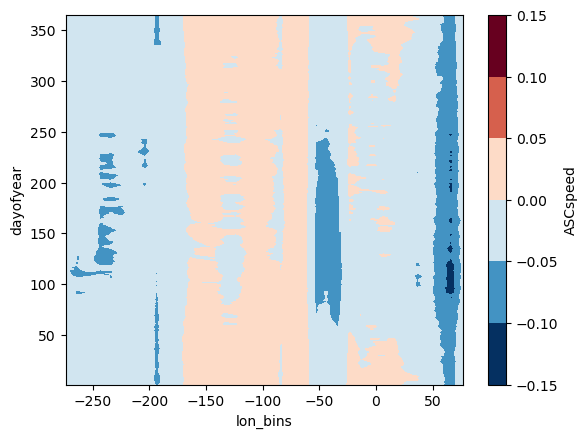

In [135]:
U_along_binned_CDW_daily_clima.ASCspeed.plot.contourf()

### Now compute the correlations:

In [5]:
files_path = '/g/data/v45/qo9901/ASC_collab_CSHT_ds/'

In [138]:
def water_mass_daily(U_along_daily_binned,  CSHT_daily_binned):
        
    len_lonbin = len(U_along_daily_binned.lon_bins) # 10deg bins

    slope_daily = np.zeros(( len_lonbin))
    stderr_daily = np.zeros((len_lonbin))
    r_sq_daily = np.zeros((len_lonbin))
    
    for i in range(len_lonbin):

        slope_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).slope
        stderr_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).stderr
        r_sq_daily[i] = stats.linregress(U_along_daily_binned[:,i], CSHT_daily_binned[:,i]/1e12).rvalue**2

    return slope_daily, stderr_daily, r_sq_daily

In [139]:
slope_daily, stderr_daily, r_sq_daily = water_mass_daily(U_along_binned_CDW_daily_clima.ASCspeed,  CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned) 

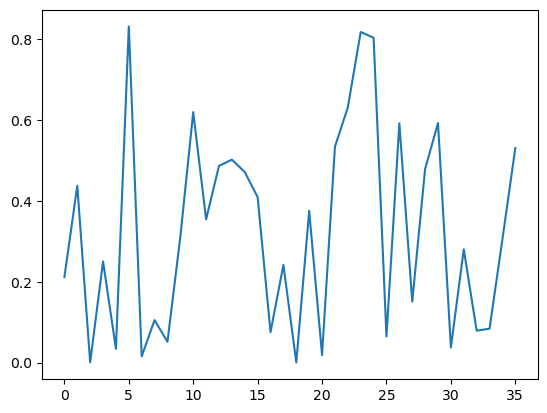

In [140]:
plt.plot(r_sq_daily)

In [141]:
file_extension = 'agemaskCDW_daily'
coordinatesBin=dict(lon_bins=(['lon_bins'], U_along_binned_CDW_daily_clima.lon_bins.data))

slope_clima_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['lon_bins'])
stderr_clima_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['lon_bins'])
r_sq_clima_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['lon_bins'])
slope_clima_xr.name = 'slope_clima'
stderr_clima_xr.name = 'stderr_clima'
r_sq_clima_xr.name = 'r_sq_clim'

slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins_' + file_extension + '_corr.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins_' + file_extension + '_corr.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins_' + file_extension + '_corr.nc', mode='w', format="NETCDF4")


In [142]:
slope_daily, stderr_daily, r_sq_daily = water_mass_daily(U_along_binned_AASW_daily_clima.ASCspeed,  CSHT_binned_AASW_daily_clima.CSHT_ZC_lon_binned) 

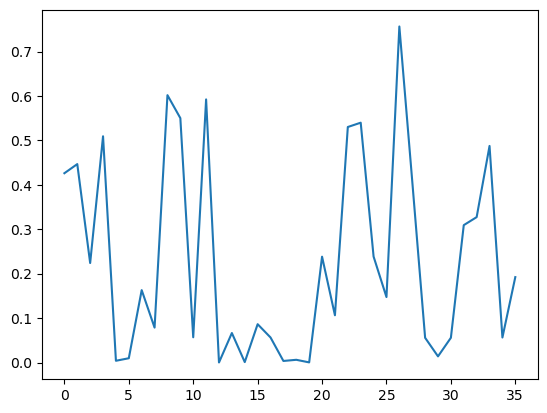

In [143]:
plt.plot(r_sq_daily)

In [144]:
file_extension = 'agemaskAASW_daily'
coordinatesBin=dict(lon_bins=(['lon_bins'], U_along_binned_AASW_daily_clima.lon_bins.data))

slope_clima_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['lon_bins'])
stderr_clima_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['lon_bins'])
r_sq_clima_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['lon_bins'])
slope_clima_xr.name = 'slope_clima'
stderr_clima_xr.name = 'stderr_clima'
r_sq_clima_xr.name = 'r_sq_clim'

slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins_' + file_extension + '_corr.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins_' + file_extension + '_corr.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins_' + file_extension + '_corr.nc', mode='w', format="NETCDF4")


## hide

In [184]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_clima_binned_CDW.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned )

In [187]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskCDW')

In [78]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW_volav.U, U_along_annual_binned_CDW_volav.U, U_along_clima_binned_CDW_volav.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned )

In [80]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskCDW_volav')

In [42]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_AASW_volav.U, U_along_annual_binned_AASW_volav.U, U_along_clima_binned_AASW_volav.U,\
                    CSHT_layerwise_binned_AASW.CSHT_ZC_lon_binned, CSHT_annual_binned_AASW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_AASW.CSHT_ZC_lon_binned )

In [43]:
slope_annual, slope_clima

(array([ 2.23883584e+00,  9.44637445e-02,  6.93285513e+00,  1.58359076e+00,
         6.64218893e-01, -8.22562419e+00,  1.93330466e+01, -2.91545748e+00,
         6.89392473e+00, -4.07464407e+01, -1.14708813e+02, -1.98836000e+00,
         9.78061609e+00,  2.03231753e+01,  4.30661949e+00,  2.19473967e+01,
         3.95288830e+01,  7.12131152e+00, -6.19064098e+00,  4.56363619e+01,
         3.86333539e+01,  4.63266112e+01, -7.39201505e+00,  3.36636202e-01,
         8.68382875e+00, -4.52398641e+00, -1.44095852e+00, -4.65193237e+00,
         2.09082467e+00,  2.30077479e+00,  1.72896029e+00, -7.71203494e-02,
        -4.03375821e-01, -2.77235512e+00, -5.65553141e+00,  7.95842341e+00]),
 array([ -3.51127305,  -9.46062524,  -7.17867741, -12.14565163,
          3.39192846,  -6.09721953,  13.74681293,  -4.62828052,
        -54.83225212,  90.47281998, -57.7183487 ,  37.99029854,
         -8.61275023, -48.07613632,  -5.83519342, -17.74784008,
         38.56280335,  -4.80846664,   3.39234864,  -9.1466

In [44]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskAASW_volav')

In [ ]:
# DAILY CLIMATOLOGY   , 

In [190]:
U_along_binned_CDW_daily_clima#.load()

<xarray.Dataset> Size: 108kB
Dimensions:    (dayofyear: 365, lon_bins: 36)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lon_bins   (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    ASCspeed   (dayofyear, lon_bins) float64 105kB -0.1008 -0.09182 ... -0.09469

In [224]:
stats.linregress(U_along_binned_CDW_daily_clima.ASCspeed.T[:,0], CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned[:,0])

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

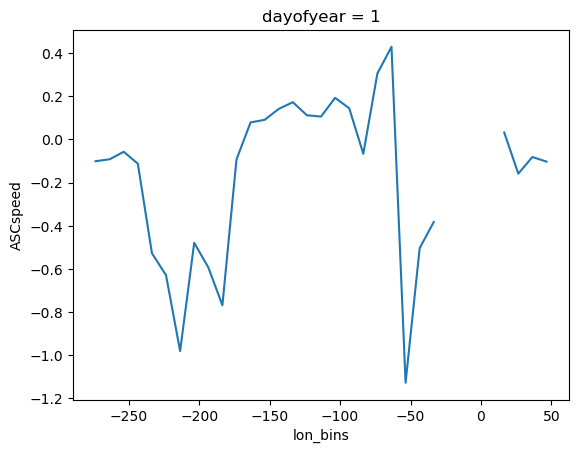

In [225]:
U_along_binned_CDW_daily_clima.ASCspeed.T[:,0].plot()

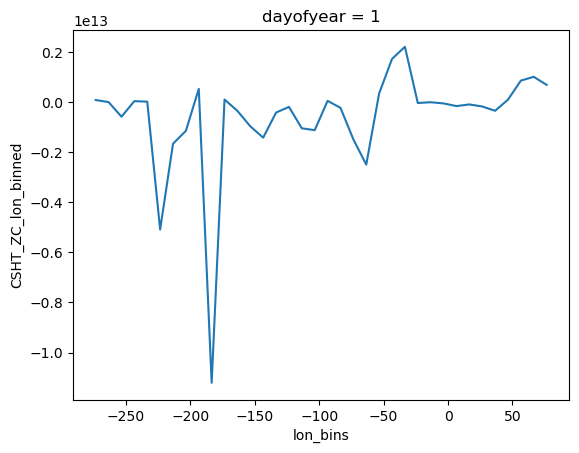

In [226]:
 CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned[:,0].plot()

In [192]:
_______, _______, slope_daily_clima, _______, _______, stderr_daily_clima, \
    _______, _______, r_sq_daily_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_binned_CDW_daily_clima.ASCspeed.T,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_binned_CDW_daily_clima.CSHT_ZC_lon_binned )

In [194]:
save_rsq_netcdf(slope_annual, slope_all, slope_daily_clima, stderr_annual, stderr_all, stderr_daily_clima, \
    r_sq_annual, r_sq_all, r_sq_daily_clima, 'agemaskCDW_daily')

NameError: name 'slope_annual' is not defined